In [1]:
# biblioteki
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
import numpy as np

Wykorzystany zbiór: https://sites.google.com/view/danish-fungi-dataset

In [3]:
# Ścieżki do plików CSV i folderu ze zdjęciami
metadata_train_path = '/Users/milenabiernacka/Desktop/praca-magisterska/DF/DF20M-metadata/DF20M-train_metadata_PROD.csv'
metadata_test_path = '/Users/milenabiernacka/Desktop/praca-magisterska/DF/DF20M-metadata/DF20M-public_test_metadata_PROD.csv'
images_folder_path = '/Users/milenabiernacka/Desktop/praca-magisterska/DF/DF20M'

# Wczytanie metadanych
metadata_train = pd.read_csv(metadata_train_path)
metadata_test = pd.read_csv(metadata_test_path)

In [4]:
metadata_train.head()

,gbifID,eventDate,year,month,day,countryCode,locality,taxonID,scientificName,kingdom,...,level2Gid,level2Name,ImageUniqueID,Substrate,rightsHolder,Latitude,Longitude,CoorUncert,Habitat,image_path
0,2862684394,2020-09-17T00:00:00,2020.0,9.0,17.0,DK,"Langesø, Morud",17215.0,Mycena crocata (Schrad.) P.Kumm.,Fungi,...,DNK.5.14_1,Nordfyns,2862684394-136762,dead wood (including bark),Uffe Nygaard,55.433810,10.200162,10.0,Unmanaged deciduous woodland,2862684394-136762.JPG
1,2238502117,2017-08-16T00:00:00,2017.0,8.0,16.0,DK,Virum,10057.0,Agaricus augustus Fr.,Fungi,...,DNK.1.28_1,Rudersdal,2238502117-320693,soil,Michael Hansen,55.800171,12.478571,5.0,garden,2238502117-320693.JPG
2,2818074328,2020-07-23T00:00:00,2020.0,7.0,23.0,DK,"Gribskov, Enghavehus",20027.0,Russula olivacea (Schaeff.) Fr.,Fungi,...,DNK.1.20_1,Hillerød,2818074328-59948,soil,Anna ploug,55.976322,12.293878,1.0,Mixed woodland (with coniferous and deciduous ...,2818074328-59948.JPG
3,2238560017,2018-09-09T00:00:00,2018.0,9.0,9.0,DK,Færgelunden,11069.0,Boletus edulis Bull.,Fungi,...,DNK.1.11_1,Frederikssund,2238560017-331396,soil,Henrik Dalgaard,55.840458,12.027228,15.0,Deciduous woodland,2238560017-331396.JPG
4,2237970493,2011-08-20T00:00:00,2011.0,8.0,20.0,DK,Tofte Skov,17278.0,Mycena pseudocorticola Kühner,Fungi,...,DNK.3.1_1,Aalborg,2237970493-5168,bark,David Boertmann,56.844840,10.192650,75.0,Forest bog,2237970493-5168.JPG


In [5]:
metadata_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3640 entries, 0 to 3639
Data columns (total 33 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   gbifID                3640 non-null   int64  
 1   eventDate             3639 non-null   object 
 2   year                  3639 non-null   float64
 3   month                 3639 non-null   float64
 4   day                   3639 non-null   float64
 5   countryCode           3640 non-null   object 
 6   locality              3636 non-null   object 
 7   taxonID               3640 non-null   float64
 8   scientificName        3640 non-null   object 
 9   kingdom               3640 non-null   object 
 10  phylum                3640 non-null   object 
 11  class                 3640 non-null   object 
 12  order                 3640 non-null   object 
 13  family                3640 non-null   object 
 14  genus                 3640 non-null   object 
 15  specificEpithet      

In [6]:
# Upewnij się, że kolumna 'image_path' jest w obu ramkach danych
metadata_train['full_image_path'] = metadata_train['image_path'].apply(lambda x: os.path.join(images_folder_path, x))
metadata_test['full_image_path'] = metadata_test['image_path'].apply(lambda x: os.path.join(images_folder_path, x))

In [7]:
metadata_train['full_image_path'][0]

'/Users/milenabiernacka/Desktop/praca-magisterska/DF/DF20M/2862684394-136762.JPG'

In [8]:
metadata_test.head()

,gbifID,eventDate,year,month,day,countryCode,locality,taxonID,scientificName,kingdom,...,level2Name,ImageUniqueID,Substrate,rightsHolder,Latitude,Longitude,CoorUncert,Habitat,image_path,full_image_path
0,2238504270,2017-08-20T00:00:00,2017.0,8.0,20.0,DK,Store Dyrehave,20020.0,Russula nigricans (Bull.) Fr.,Fungi,...,Hillerød,2238504270-171705,soil,Dan Ingemann Jensen,55.905585,12.362367,75.0,Deciduous woodland,2238504270-171705.JPG,/Users/milenabiernacka/Desktop/praca-magisters...
1,2238511676,2017-09-17T00:00:00,2017.0,9.0,17.0,DK,Store Hareskov,17238.0,Mycena haematopus (Pers.) P.Kumm.,Fungi,...,Furesø,2238511676-246956,dead wood (including bark),Tarquin Netherway,55.769675,12.401108,15.0,Deciduous woodland,2238511676-246956.JPG,/Users/milenabiernacka/Desktop/praca-magisters...
2,2883271536,2020-10-18T00:00:00,2020.0,10.0,18.0,DK,Lillerød,17289.0,Mycena rosea (Schumach.) Gramberg,Fungi,...,Allerød,2883271536-291057,soil,Dan Ingemann Jensen,55.878946,12.359130,40.0,Deciduous woodland,2883271536-291057.JPG,/Users/milenabiernacka/Desktop/praca-magisters...
3,2446759186,2019-10-26T00:00:00,2019.0,10.0,26.0,DK,Ollerup,10079.0,Agaricus impudicus (Rea) Pilát,Fungi,...,Svendborg,2446759186-271681,soil,Dan Schou,55.068441,10.515358,50.0,Unmanaged deciduous woodland,2446759186-271681.JPG,/Users/milenabiernacka/Desktop/praca-magisters...
4,2382321410,2019-08-30T00:00:00,2019.0,8.0,30.0,DK,"Dyrehave, Valdemars Slot (inkl Pederskov)",19939.0,Russula chloroides (Krombh.) Bres.,Fungi,...,Svendborg,2382321410-191132,soil,Kirsten Bjørnsson,55.013310,10.644585,75.0,Deciduous woodland,2382321410-191132.JPG,/Users/milenabiernacka/Desktop/praca-magisters...


In [9]:
metadata_train['scientificName'].value_counts()

scientificName
Mycena galericulata (Scop.) Gray       1099
Clitocybe nebularis (Batsch) Quél.     1003
Amanita muscaria (L.) Lam., 1783        863
Boletus edulis Bull.                    811
Amanita rubescens (Pers.) Gray          713
                                       ... 
Agaricus bisporus (J.E.Lange) Pilat      33
Russula laeta Jul.Schäff.                32
Clitocybe diatreta (Fr.) P.Kumm.         32
Clitocybe nitrophila Bon                 29
Russula insignis Quél.                   28
Name: count, Length: 182, dtype: int64

In [9]:
from sklearn.preprocessing import LabelEncoder

# Zakodowanie etykiet
label_encoder = LabelEncoder()
metadata_train['class_encoded'] = label_encoder.fit_transform(metadata_train['scientificName'])
metadata_test['class_encoded'] = label_encoder.transform(metadata_test['scientificName'])  # Uwaga: używamy transform, nie fit_transform

In [10]:
metadata_train.head()

,gbifID,eventDate,year,month,day,countryCode,locality,taxonID,scientificName,kingdom,...,ImageUniqueID,Substrate,rightsHolder,Latitude,Longitude,CoorUncert,Habitat,image_path,full_image_path,class_encoded
0,2862684394,2020-09-17T00:00:00,2020.0,9.0,17.0,DK,"Langesø, Morud",17215.0,Mycena crocata (Schrad.) P.Kumm.,Fungi,...,2862684394-136762,dead wood (including bark),Uffe Nygaard,55.433810,10.200162,10.0,Unmanaged deciduous woodland,2862684394-136762.JPG,/Users/milenabiernacka/Desktop/studia/magister...,70
1,2238502117,2017-08-16T00:00:00,2017.0,8.0,16.0,DK,Virum,10057.0,Agaricus augustus Fr.,Fungi,...,2238502117-320693,soil,Michael Hansen,55.800171,12.478571,5.0,garden,2238502117-320693.JPG,/Users/milenabiernacka/Desktop/studia/magister...,1
2,2818074328,2020-07-23T00:00:00,2020.0,7.0,23.0,DK,"Gribskov, Enghavehus",20027.0,Russula olivacea (Schaeff.) Fr.,Fungi,...,2818074328-59948,soil,Anna ploug,55.976322,12.293878,1.0,Mixed woodland (with coniferous and deciduous ...,2818074328-59948.JPG,/Users/milenabiernacka/Desktop/studia/magister...,151
3,2238560017,2018-09-09T00:00:00,2018.0,9.0,9.0,DK,Færgelunden,11069.0,Boletus edulis Bull.,Fungi,...,2238560017-331396,soil,Henrik Dalgaard,55.840458,12.027228,15.0,Deciduous woodland,2238560017-331396.JPG,/Users/milenabiernacka/Desktop/studia/magister...,40
4,2237970493,2011-08-20T00:00:00,2011.0,8.0,20.0,DK,Tofte Skov,17278.0,Mycena pseudocorticola Kühner,Fungi,...,2237970493-5168,bark,David Boertmann,56.844840,10.192650,75.0,Forest bog,2237970493-5168.JPG,/Users/milenabiernacka/Desktop/studia/magister...,89


In [11]:
# Definicja ImageDataGeneratorów
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
metadata_train.head()

,gbifID,eventDate,year,month,day,countryCode,locality,taxonID,scientificName,kingdom,...,ImageUniqueID,Substrate,rightsHolder,Latitude,Longitude,CoorUncert,Habitat,image_path,full_image_path,class_encoded
0,2862684394,2020-09-17T00:00:00,2020.0,9.0,17.0,DK,"Langesø, Morud",17215.0,Mycena crocata (Schrad.) P.Kumm.,Fungi,...,2862684394-136762,dead wood (including bark),Uffe Nygaard,55.433810,10.200162,10.0,Unmanaged deciduous woodland,2862684394-136762.JPG,/Users/milenabiernacka/Desktop/studia/magister...,70
1,2238502117,2017-08-16T00:00:00,2017.0,8.0,16.0,DK,Virum,10057.0,Agaricus augustus Fr.,Fungi,...,2238502117-320693,soil,Michael Hansen,55.800171,12.478571,5.0,garden,2238502117-320693.JPG,/Users/milenabiernacka/Desktop/studia/magister...,1
2,2818074328,2020-07-23T00:00:00,2020.0,7.0,23.0,DK,"Gribskov, Enghavehus",20027.0,Russula olivacea (Schaeff.) Fr.,Fungi,...,2818074328-59948,soil,Anna ploug,55.976322,12.293878,1.0,Mixed woodland (with coniferous and deciduous ...,2818074328-59948.JPG,/Users/milenabiernacka/Desktop/studia/magister...,151
3,2238560017,2018-09-09T00:00:00,2018.0,9.0,9.0,DK,Færgelunden,11069.0,Boletus edulis Bull.,Fungi,...,2238560017-331396,soil,Henrik Dalgaard,55.840458,12.027228,15.0,Deciduous woodland,2238560017-331396.JPG,/Users/milenabiernacka/Desktop/studia/magister...,40
4,2237970493,2011-08-20T00:00:00,2011.0,8.0,20.0,DK,Tofte Skov,17278.0,Mycena pseudocorticola Kühner,Fungi,...,2237970493-5168,bark,David Boertmann,56.844840,10.192650,75.0,Forest bog,2237970493-5168.JPG,/Users/milenabiernacka/Desktop/studia/magister...,89


In [15]:
metadata_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32753 entries, 0 to 32752
Data columns (total 35 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   gbifID                32753 non-null  int64  
 1   eventDate             32748 non-null  object 
 2   year                  32748 non-null  float64
 3   month                 32748 non-null  float64
 4   day                   32748 non-null  float64
 5   countryCode           32753 non-null  object 
 6   locality              32737 non-null  object 
 7   taxonID               32753 non-null  float64
 8   scientificName        32753 non-null  object 
 9   kingdom               32753 non-null  object 
 10  phylum                32753 non-null  object 
 11  class                 32753 non-null  object 
 12  order                 32753 non-null  object 
 13  family                32753 non-null  object 
 14  genus                 32753 non-null  object 
 15  specificEpithet    

In [16]:
# Utwórz teraz zmniejszone próbki danych
train_sample = metadata_train.sample(frac=0.2, random_state=42) 
test_sample = metadata_test.sample(frac=0.2, random_state=42) 

# Lista wszystkich unikalnych klas z oryginalnego DataFrame
all_classes = sorted(metadata_train['scientificName'].unique().tolist())

# Tworzenie generatorów z jawnie określoną listą klas
train_generator_sample = train_datagen.flow_from_dataframe(
    dataframe=train_sample,
    x_col='full_image_path',
    y_col='scientificName',
    target_size=(224, 224),
    batch_size=32,
    classes=all_classes,  # Zapewnij listę wszystkich klas
    class_mode='categorical')

test_generator_sample = test_datagen.flow_from_dataframe(
    dataframe=test_sample,
    x_col='full_image_path',
    y_col='scientificName',
    target_size=(224, 224),
    batch_size=32,
    classes=all_classes,  # Zapewnij listę wszystkich klas
    class_mode='categorical')


Found 6551 validated image filenames belonging to 182 classes.
Found 728 validated image filenames belonging to 182 classes.


In [17]:
# Wczytanie MobileNetV2 bez górnych warstw
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Dodanie górnych warstw
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(label_encoder.classes_), activation='softmax')(x)  # liczba neuronów odpowiada liczbie klas

# Zbudowanie całego modelu
model = Model(inputs=base_model.input, outputs=predictions)

# Kompilacja modelu
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Trening modelu
model.fit(train_generator_sample, validation_data=test_generator_sample, epochs=10, steps_per_epoch=train_generator_sample.samples // train_generator_sample.batch_size,
          validation_steps=len(test_generator_sample))

Epoch 1/10
204/204 [==============================] - 290s 1s/step - loss: 4.3618 - accuracy: 0.1088 - val_loss: 18.8836 - val_accuracy: 0.0096
Epoch 2/10
204/204 [==============================] - 290s 1s/step - loss: 3.5540 - accuracy: 0.1902 - val_loss: 17.1339 - val_accuracy: 0.0165
Epoch 3/10
204/204 [==============================] - 295s 1s/step - loss: 3.0987 - accuracy: 0.2533 - val_loss: 16.3753 - val_accuracy: 0.0082
Epoch 4/10
204/204 [==============================] - 302s 1s/step - loss: 2.7222 - accuracy: 0.3069 - val_loss: 27.6825 - val_accuracy: 0.0124
Epoch 5/10
204/204 [==============================] - 296s 1s/step - loss: 2.4315 - accuracy: 0.3576 - val_loss: 9.5334 - val_accuracy: 0.0234
Epoch 6/10
204/204 [==============================] - 325s 2s/step - loss: 2.1972 - accuracy: 0.4094 - val_loss: 10.2197 - val_accuracy: 0.0302
Epoch 7/10
204/204 [==============================] - 354s 2s/step - loss: 1.9539 - accuracy: 0.4617 - val_loss: 10.3734 - val_accuracy: 

In [18]:
test_loss, test_accuracy = model.evaluate(test_generator_sample, steps=test_generator_sample.samples // test_generator_sample.batch_size)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

22/22 [==============================] - 15s 693ms/step - loss: 11.3220 - accuracy: 0.0170
Test Loss: 11.322044372558594, Test Accuracy: 0.017045455053448677


In [19]:
model.evaluate(test_generator_sample)

23/23 [==============================] - 16s 696ms/step - loss: 11.2848 - accuracy: 0.0179


[11.284760475158691, 0.01785714365541935]

In [1]:
print("hi")

hi


# Danish Fungi Validation Set

In [75]:
metadata_path = '/Users/milenabiernacka/Desktop/praca-magisterska/DF/validation/FungiCLEF2023_val_metadata_PRODUCTION.csv'
photos_path = '/Users/milenabiernacka/Desktop/praca-magisterska/DF/validation/DF21_300'

metadata = pd.read_csv(metadata_path)
metadata.head()

,observationID,month,day,countryCode,locality,taxonID,scientificName,kingdom,phylum,class,...,Substrate,Latitude,Longitude,CoorUncert,Habitat,image_path,filename,MetaSubstrate,class_id,poisonous
0,3008834344,1.0,1.0,DK,Kildevænget,15233,Hypoxylon fragiforme (Pers.) J.Kickx f.,Fungi,Ascomycota,Sordariomycetes,...,NaN,55.946963,12.292050,31.0,Deciduous woodland,0-3008834344.JPG,0-3008834344,wood,702,0
1,3008834345,1.0,1.0,DK,Kildevænget,14428,Gymnopilus penetrans (Fr.) Murrill,Fungi,Basidiomycota,Agaricomycetes,...,NaN,55.947665,12.287160,16.0,coniferous woodland/plantation,0-3008834345.JPG,0-3008834345,wood,553,0
2,3008834345,1.0,1.0,DK,Kildevænget,14428,Gymnopilus penetrans (Fr.) Murrill,Fungi,Basidiomycota,Agaricomycetes,...,NaN,55.947665,12.287160,16.0,coniferous woodland/plantation,1-3008834345.JPG,1-3008834345,wood,553,0
3,3008834353,1.0,1.0,DK,"Norup, Vammen",12226,Cordyceps militaris (L.) Link,Fungi,Ascomycota,Sordariomycetes,...,mosses,56.529817,9.550255,30.0,coniferous woodland/plantation,0-3008834353.JPG,0-3008834353,mosses,267,0
4,3008834353,1.0,1.0,DK,"Norup, Vammen",12226,Cordyceps militaris (L.) Link,Fungi,Ascomycota,Sordariomycetes,...,mosses,56.529817,9.550255,30.0,coniferous woodland/plantation,1-3008834353.JPG,1-3008834353,mosses,267,0


In [76]:
metadata['full_image_path'] = metadata['image_path'].apply(lambda x: os.path.join(photos_path, x))

In [77]:
metadata.head()

,observationID,month,day,countryCode,locality,taxonID,scientificName,kingdom,phylum,class,...,Latitude,Longitude,CoorUncert,Habitat,image_path,filename,MetaSubstrate,class_id,poisonous,full_image_path
0,3008834344,1.0,1.0,DK,Kildevænget,15233,Hypoxylon fragiforme (Pers.) J.Kickx f.,Fungi,Ascomycota,Sordariomycetes,...,55.946963,12.292050,31.0,Deciduous woodland,0-3008834344.JPG,0-3008834344,wood,702,0,/Users/milenabiernacka/Desktop/praca-magisters...
1,3008834345,1.0,1.0,DK,Kildevænget,14428,Gymnopilus penetrans (Fr.) Murrill,Fungi,Basidiomycota,Agaricomycetes,...,55.947665,12.287160,16.0,coniferous woodland/plantation,0-3008834345.JPG,0-3008834345,wood,553,0,/Users/milenabiernacka/Desktop/praca-magisters...
2,3008834345,1.0,1.0,DK,Kildevænget,14428,Gymnopilus penetrans (Fr.) Murrill,Fungi,Basidiomycota,Agaricomycetes,...,55.947665,12.287160,16.0,coniferous woodland/plantation,1-3008834345.JPG,1-3008834345,wood,553,0,/Users/milenabiernacka/Desktop/praca-magisters...
3,3008834353,1.0,1.0,DK,"Norup, Vammen",12226,Cordyceps militaris (L.) Link,Fungi,Ascomycota,Sordariomycetes,...,56.529817,9.550255,30.0,coniferous woodland/plantation,0-3008834353.JPG,0-3008834353,mosses,267,0,/Users/milenabiernacka/Desktop/praca-magisters...
4,3008834353,1.0,1.0,DK,"Norup, Vammen",12226,Cordyceps militaris (L.) Link,Fungi,Ascomycota,Sordariomycetes,...,56.529817,9.550255,30.0,coniferous woodland/plantation,1-3008834353.JPG,1-3008834353,mosses,267,0,/Users/milenabiernacka/Desktop/praca-magisters...


In [78]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60832 entries, 0 to 60831
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   observationID    60832 non-null  int64  
 1   month            60832 non-null  float64
 2   day              60832 non-null  float64
 3   countryCode      60832 non-null  object 
 4   locality         60813 non-null  object 
 5   taxonID          60832 non-null  int64  
 6   scientificName   60832 non-null  object 
 7   kingdom          60832 non-null  object 
 8   phylum           60832 non-null  object 
 9   class            60787 non-null  object 
 10  order            60664 non-null  object 
 11  family           60394 non-null  object 
 12  genus            60832 non-null  object 
 13  specificEpithet  60832 non-null  object 
 14  taxonRank        60832 non-null  object 
 15  species          60832 non-null  object 
 16  level0Gid        60639 non-null  object 
 17  level0Name  

In [79]:
half_metadata = metadata.sample(frac=0.2, random_state=42)

In [80]:
half_metadata.head()

,observationID,month,day,countryCode,locality,taxonID,scientificName,kingdom,phylum,class,...,Latitude,Longitude,CoorUncert,Habitat,image_path,filename,MetaSubstrate,class_id,poisonous,full_image_path
48791,3052841406,3.0,3.0,DK,Filsø Gårde,13952,Exidia glandulosa (Bull.) Fr.,Fungi,Basidiomycota,Agaricomycetes,...,56.245372,8.412633,6.0,Unmanaged deciduous woodland,0-3052841406.JPG,0-3052841406,wood,468,0,/Users/milenabiernacka/Desktop/praca-magisters...
14384,3386480353,10.0,12.0,DK,Overlund,15850,Lactarius glyciosmus (Fr.) Fr.,Fungi,Basidiomycota,Agaricomycetes,...,56.458939,9.441329,28.0,natural grassland,0-3386480353.JPG,0-3386480353,jord,774,0,/Users/milenabiernacka/Desktop/praca-magisters...
11713,3399806330,10.0,30.0,DK,Kulebjerg Overdrev,16660,Macrolepiota procera (Scop.) Singer,Fungi,Basidiomycota,Agaricomycetes,...,55.543602,11.439074,25.0,natural grassland,1-3399806330.JPG,1-3399806330,jord,-1,0,/Users/milenabiernacka/Desktop/praca-magisters...
3803,3091023316,4.0,22.0,DK,Greve Strand,69190,Gemmina gemmarum (Boud.) Raitv.,Fungi,Ascomycota,Leotiomycetes,...,55.593711,12.294706,65.0,Thorny scrubland,5-3091023316.JPG,5-3091023316,plant material,-1,0,/Users/milenabiernacka/Desktop/praca-magisters...
37397,3336954336,8.0,18.0,DK,Ahl Plantage,15908,Lactarius quietus (Fr.) Fr.,Fungi,Basidiomycota,Agaricomycetes,...,56.179937,10.640115,10.0,bog,1-3336954336.JPG,1-3336954336,jord,787,0,/Users/milenabiernacka/Desktop/praca-magisters...


In [81]:
half_metadata.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12166 entries, 48791 to 4199
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   observationID    12166 non-null  int64  
 1   month            12166 non-null  float64
 2   day              12166 non-null  float64
 3   countryCode      12166 non-null  object 
 4   locality         12164 non-null  object 
 5   taxonID          12166 non-null  int64  
 6   scientificName   12166 non-null  object 
 7   kingdom          12166 non-null  object 
 8   phylum           12166 non-null  object 
 9   class            12154 non-null  object 
 10  order            12123 non-null  object 
 11  family           12063 non-null  object 
 12  genus            12166 non-null  object 
 13  specificEpithet  12166 non-null  object 
 14  taxonRank        12166 non-null  object 
 15  species          12166 non-null  object 
 16  level0Gid        12123 non-null  object 
 17  level0Name    

In [82]:
data = half_metadata[['species', 'full_image_path', 'image_path', 'poisonous']]
data.head()

,species,full_image_path,image_path,poisonous
48791,Exidia glandulosa,/Users/milenabiernacka/Desktop/praca-magisters...,0-3052841406.JPG,0
14384,Lactarius glyciosmus,/Users/milenabiernacka/Desktop/praca-magisters...,0-3386480353.JPG,0
11713,Macrolepiota procera,/Users/milenabiernacka/Desktop/praca-magisters...,1-3399806330.JPG,0
3803,Gemmina gemmarum,/Users/milenabiernacka/Desktop/praca-magisters...,5-3091023316.JPG,0
37397,Lactarius quietus,/Users/milenabiernacka/Desktop/praca-magisters...,1-3336954336.JPG,0


In [83]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12166 entries, 48791 to 4199
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   species          12166 non-null  object
 1   full_image_path  12166 non-null  object
 2   image_path       12166 non-null  object
 3   poisonous        12166 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 475.2+ KB


In [84]:
print(data['species'].value_counts())

species
Micarea lignaria           107
Trametes versicolor         84
Fomitopsis pinicola         77
Stereum hirsutum            63
Calocybe gambosa            61
                          ... 
Seimatosporium vaccinii      1
Cistella grevillei           1
Entoloma sanvitalense        1
Cortinarius triumphans       1
Russula acrifolia            1
Name: count, Length: 1975, dtype: int64


In [85]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(data, test_size=0.2, random_state=42)

In [86]:
X_train

,species,full_image_path,image_path,poisonous
20731,Auricularia mesenterica,/Users/milenabiernacka/Desktop/praca-magisters...,0-3417636331.JPG,0
34006,Agrocybe praecox,/Users/milenabiernacka/Desktop/praca-magisters...,3-3131201304.JPG,0
41870,Pseudohydnum gelatinosum,/Users/milenabiernacka/Desktop/praca-magisters...,0-3406486316.JPG,0
2069,Xylaria longipes,/Users/milenabiernacka/Desktop/praca-magisters...,0-3380899518.JPG,0
34941,Parasola plicatilis,/Users/milenabiernacka/Desktop/praca-magisters...,3-3358349362.JPG,0
...,...,...,...,...
54666,Lecidella elaeochroma,/Users/milenabiernacka/Desktop/praca-magisters...,0-3014640388.JPG,0
46183,Imshaugia aleurites,/Users/milenabiernacka/Desktop/praca-magisters...,0-3113020335.JPG,0
38144,Mycena rosea,/Users/milenabiernacka/Desktop/praca-magisters...,0-3382568339.JPG,1
1165,Podosphaera balsaminae,/Users/milenabiernacka/Desktop/praca-magisters...,1-3329732343.JPG,0


In [87]:
X_train, X_val = train_test_split(X_train, test_size=0.2, random_state=42)

In [88]:
X_val

,species,full_image_path,image_path,poisonous
18393,Micarea lignaria,/Users/milenabiernacka/Desktop/praca-magisters...,1-3052916313.JPG,0
25862,Coprinopsis picacea,/Users/milenabiernacka/Desktop/praca-magisters...,2-3380905383.JPG,0
39957,Flavoparmelia caperata,/Users/milenabiernacka/Desktop/praca-magisters...,0-3116975311.JPG,0
33047,Geastrum michelianum,/Users/milenabiernacka/Desktop/praca-magisters...,2-3419929381.JPG,0
49279,Arthonia varians,/Users/milenabiernacka/Desktop/praca-magisters...,0-3126932311.JPG,0
...,...,...,...,...
53488,Mycena rosea,/Users/milenabiernacka/Desktop/praca-magisters...,3-3380894451.JPG,1
1349,Lactarius tabidus,/Users/milenabiernacka/Desktop/praca-magisters...,4-3343244303.JPG,0
45711,Diatrypella quercina,/Users/milenabiernacka/Desktop/praca-magisters...,0-3070937307.JPG,0
16597,Tricholomopsis rutilans,/Users/milenabiernacka/Desktop/praca-magisters...,2-3345598387.JPG,0


In [89]:
X_train['species'].nunique()

1679

<Axes: xlabel='species'>

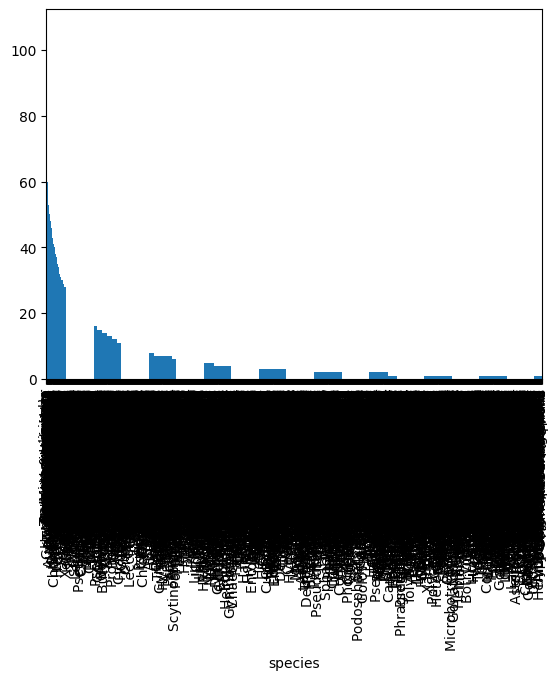

In [90]:
data['species'].value_counts().plot(kind='bar')

# Augmentacja

In [91]:
class_counts = data['species'].value_counts()
print(class_counts)

species
Micarea lignaria           107
Trametes versicolor         84
Fomitopsis pinicola         77
Stereum hirsutum            63
Calocybe gambosa            61
                          ... 
Seimatosporium vaccinii      1
Cistella grevillei           1
Entoloma sanvitalense        1
Cortinarius triumphans       1
Russula acrifolia            1
Name: count, Length: 1975, dtype: int64


In [92]:
from sklearn.utils import resample

# Załóżmy, że target_count to docelowa liczba próbek, którą chcesz mieć dla każdej klasy
target_count = 10

augmented_data = []
for class_name, count in class_counts.items():
    class_subset = data[data['species'] == class_name]  # Wybierz wszystkie przykłady tej klasy
    n_samples_to_generate = max(0, target_count - count)  # Upewnij się, że liczba jest nieujemna

    if n_samples_to_generate > 0:
        # Tylko wtedy wykonaj augmentację, jeśli trzeba wygenerować dodatkowe próbki
        augmented_class_samples = resample(class_subset,
                                           replace=True,  # próbkowanie ze zwracaniem
                                           n_samples=n_samples_to_generate,  # liczba próbek do wygenerowania
                                           random_state=42)
        
        # Tutaj powinieneś zastosować augmentację danych, ale pominę ten krok dla uproszczenia
        # Pamiętaj, że musisz zastosować augmentację ręcznie na wybranych próbkach

        augmented_data.append(augmented_class_samples)

# Po wygenerowaniu augmentowanych danych, dodaj je do oryginalnego zbioru treningowego
augmented_data = pd.concat(augmented_data, ignore_index=True) if augmented_data else pd.DataFrame()
train_data_augmented = pd.concat([data, augmented_data], ignore_index=True)


In [93]:
train_data_augmented.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23827 entries, 0 to 23826
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   species          23827 non-null  object
 1   full_image_path  23827 non-null  object
 2   image_path       23827 non-null  object
 3   poisonous        23827 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 744.7+ KB


<Axes: xlabel='species'>

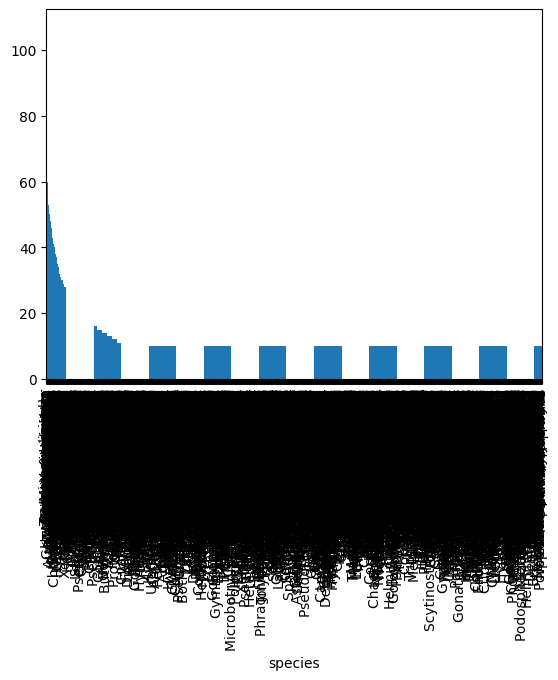

In [94]:
train_data_augmented['species'].value_counts().plot(kind='bar')

In [95]:
# Podział danych na zbiór treningowy i pozostałe dane (testowy + walidacyjny)
train_data, test_val_data = train_test_split(train_data_augmented, test_size=0.4, random_state=42, stratify=train_data_augmented['species'])

# Podział pozostałych danych na zbiór testowy i walidacyjny
test_data, val_data = train_test_split(test_val_data, test_size=0.5, random_state=42, stratify=test_val_data['species'])

In [107]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Ścieżka do zdjęć - upewnij się, że jest poprawna
photos_path = '/Users/milenabiernacka/Desktop/praca-magisterska/DF/DF21_300'

# Utwórz generator obrazów z augmentacją danych dla zbioru treningowego
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Utwórz generator obrazów bez augmentacji danych dla zbioru walidacyjnego i testowego
datagen_test_val = ImageDataGenerator(
    rescale=1./255
)

# Przygotowanie generatorów
train_generator = datagen_train.flow_from_dataframe(
    dataframe=train_data,
    directory=photos_path,
    x_col='full_image_path',
    y_col='species',
    class_mode='categorical',
    target_size=(224, 224),
    batch_size=64,
    shuffle=True
)

test_generator = datagen_test_val.flow_from_dataframe(
    dataframe=test_data,
    directory=photos_path,
    x_col='full_image_path',
    y_col='species',
    class_mode='categorical',
    target_size=(224, 224),
    batch_size=64,
    shuffle=False
)

val_generator = datagen_test_val.flow_from_dataframe(
    dataframe=val_data,
    directory=photos_path,
    x_col='full_image_path',
    y_col='species',
    class_mode='categorical',
    target_size=(224, 224),
    batch_size=64,
    shuffle=False
)


Found 14296 validated image filenames belonging to 1975 classes.
Found 4765 validated image filenames belonging to 1975 classes.
Found 4766 validated image filenames belonging to 1975 classes.


In [109]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Ładowanie MobileNetV2 bez górnych warstw
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Dodanie górnych warstw
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

# Liczba klas (gatunków) do przewidywania
n_classes = len(train_generator.class_indices)
predictions = Dense(n_classes, activation='softmax')(x)

# Zbudowanie modelu
model2 = Model(inputs=base_model.input, outputs=predictions)

# Kompilacja modelu
model2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
history2 = model2.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

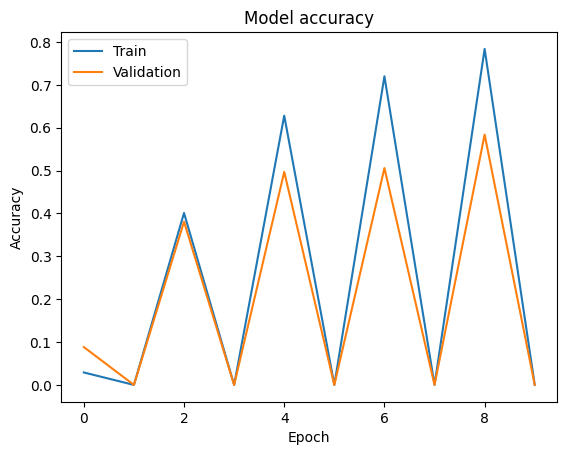

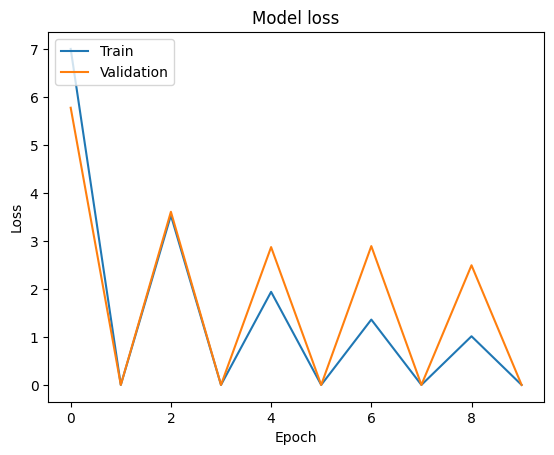

In [101]:
import matplotlib.pyplot as plt

# Wizualizacja dokładności
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Wizualizacja straty
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [102]:
# Ocena modelu na zbiorze testowym
test_loss, test_accuracy = model.evaluate(test_generator)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')


/Users/milenabiernacka/Desktop/praca-magisterska/Mushroom-classification/venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


149/149 ━━━━━━━━━━━━━━━━━━━━ 40s 260ms/step - accuracy: 5.3257e-04 - loss: 7.7087
Test Loss: 7.7002716064453125
Test Accuracy: 0.0006295907660387456


In [106]:
model.save('/Users/milenabiernacka/Desktop/praca-magisterska/Mushroom-classification/models/model_10epochs_MobileNetV2/model1.h5')  # Zapisuje model w folderze SavedModel

# Podejście next

In [17]:
half_metadata = metadata_train.sample(frac=0.25, random_state=42)

In [18]:
data = half_metadata[['species', 'full_image_path', 'image_path']]
data.head()

,species,full_image_path,image_path
3578,Agaricus litoralis,/Users/milenabiernacka/Desktop/praca-magisters...,2238304953-11531.JPG
10883,Agaricus campestris,/Users/milenabiernacka/Desktop/praca-magisters...,2238421610-164017.JPG
22251,Agaricus campestris,/Users/milenabiernacka/Desktop/praca-magisters...,2874311381-289462.JPG
25240,Amanita muscaria,/Users/milenabiernacka/Desktop/praca-magisters...,2430664044-122176.JPG
15746,Clitocybe nebularis,/Users/milenabiernacka/Desktop/praca-magisters...,2427874384-121838.JPG


In [19]:
data['species_str'] = data['species'].astype(str)
data['species'] = data['species'].astype(str)

/var/folders/s0/p8ldq2yj3j71tzmvgws_cyp40000gn/T/ipykernel_90468/2258470280.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['species_str'] = data['species'].astype(str)
/var/folders/s0/p8ldq2yj3j71tzmvgws_cyp40000gn/T/ipykernel_90468/2258470280.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['species'] = data['species'].astype(str)


In [20]:
print(data['species'].value_counts())

species
Mycena galericulata         263
Clitocybe nebularis         248
Boletus edulis              203
Amanita muscaria            202
Russula ochroleuca          180
                           ... 
Mycena luteovariegata         5
Agaricus lanipes              5
Agaricus subfloccosus         3
Amanita lividopallescens      3
Mycena rosella                3
Name: count, Length: 180, dtype: int64


In [21]:
from sklearn.utils import resample

class_counts = data['species'].value_counts()
print(class_counts)

# Załóżmy, że target_count to docelowa liczba próbek, którą chcesz mieć dla każdej klasy
target_count = 10

augmented_data = []
for class_name, count in class_counts.items():
    class_subset = data[data['species'] == class_name]  # Wybierz wszystkie przykłady tej klasy
    n_samples_to_generate = max(0, target_count - count)  # Upewnij się, że liczba jest nieujemna

    if n_samples_to_generate > 0:
        # Tylko wtedy wykonaj augmentację, jeśli trzeba wygenerować dodatkowe próbki
        augmented_class_samples = resample(class_subset,
                                           replace=True,  # próbkowanie ze zwracaniem
                                           n_samples=n_samples_to_generate,  # liczba próbek do wygenerowania
                                           random_state=42)

        # Tutaj powinieneś zastosować augmentację danych, ale pominę ten krok dla uproszczenia
        # Pamiętaj, że musisz zastosować augmentację ręcznie na wybranych próbkach

        augmented_data.append(augmented_class_samples)

# Po wygenerowaniu augmentowanych danych, dodaj je do oryginalnego zbioru treningowego
augmented_data = pd.concat(augmented_data, ignore_index=True) if augmented_data else pd.DataFrame()
train_data_augmented = pd.concat([data, augmented_data], ignore_index=True)


species
Mycena galericulata         263
Clitocybe nebularis         248
Boletus edulis              203
Amanita muscaria            202
Russula ochroleuca          180
                           ... 
Mycena luteovariegata         5
Agaricus lanipes              5
Agaricus subfloccosus         3
Amanita lividopallescens      3
Mycena rosella                3
Name: count, Length: 180, dtype: int64


In [22]:
train_data_augmented.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8264 entries, 0 to 8263
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   species          8264 non-null   object
 1   full_image_path  8264 non-null   object
 2   image_path       8264 non-null   object
 3   species_str      8264 non-null   object
dtypes: object(4)
memory usage: 258.4+ KB


<Axes: xlabel='species'>

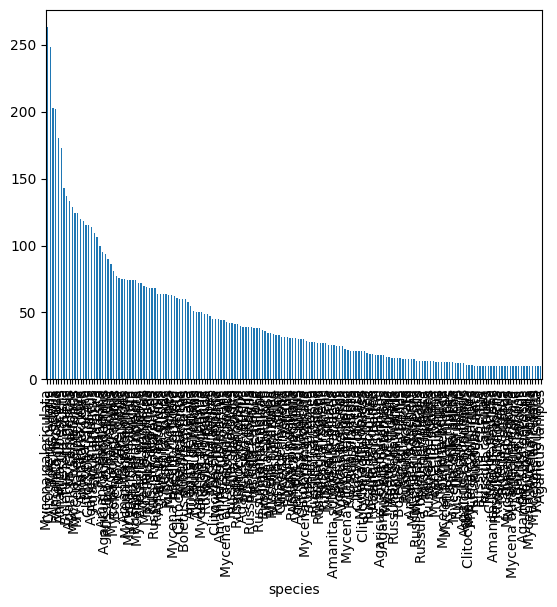

In [23]:
train_data_augmented['species'].value_counts().plot(kind='bar')

In [24]:
from sklearn.model_selection import train_test_split

# Podział danych na zbiór treningowy i pozostałe dane (testowy + walidacyjny)
train_data, test_val_data = train_test_split(train_data_augmented, test_size=0.4, random_state=42, stratify = train_data_augmented['species'])

# Podział pozostałych danych na zbiór testowy i walidacyjny
test_data, val_data = train_test_split(test_val_data, test_size=0.5, random_state=42, stratify = test_val_data['species'])

In [25]:
# Utwórz generator obrazów z augmentacją danych dla zbioru treningowego
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Utwórz generator obrazów bez augmentacji danych dla zbioru walidacyjnego i testowego
datagen_test_val = ImageDataGenerator(
    rescale=1./255
)

# Przygotowanie generatorów
train_generator = datagen_train.flow_from_dataframe(
    dataframe=train_data,
    directory=images_folder_path,
    x_col='full_image_path',
    y_col='species',
    class_mode='categorical',
    target_size=(224, 224),
    batch_size=32,
    shuffle=True
)

test_generator = datagen_test_val.flow_from_dataframe(
    dataframe=test_data,
    directory=images_folder_path,
    x_col='full_image_path',
    y_col='species',
    class_mode='categorical',
    target_size=(224, 224),
    batch_size=32,
    shuffle=False
)

val_generator = datagen_test_val.flow_from_dataframe(
    dataframe=val_data,
    directory=images_folder_path,
    x_col='full_image_path',
    y_col='species',
    class_mode='categorical',
    target_size=(224, 224),
    batch_size=32,
    shuffle=False
)

Found 4958 validated image filenames belonging to 180 classes.
Found 1653 validated image filenames belonging to 180 classes.
Found 1653 validated image filenames belonging to 180 classes.


In [28]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Ładowanie MobileNetV2 bez górnych warstw
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Dodanie górnych warstw
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)

# Liczba klas (gatunków) do przewidywania
n_classes = len(train_generator.class_indices)
predictions = Dense(n_classes, activation='softmax')(x)

# Zbudowanie modelu
model2 = Model(inputs=base_model.input, outputs=predictions)

# Kompilacja modelu
model2.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
history = model2.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

Epoch 1/20


/Users/milenabiernacka/Desktop/praca-magisterska/Mushroom-classification/venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-03-25 06:18:51.427585: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 1 of 8
2024-03-25 06:19:09.411020: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 2 of 8
2024-03-25 06:19:42.632235: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 3 of 8
2024-03-25 06:20:12.355394: I tensorflow/core/kernels/data/shuffle_da

155/155 ━━━━━━━━━━━━━━━━━━━━ 4864s 30s/step - accuracy: 0.0604 - loss: 4.8901 - val_accuracy: 0.1295 - val_loss: 4.2009
Epoch 2/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/20


2024-03-25 07:39:12.244124: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-03-25 07:39:12.265527: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


155/155 ━━━━━━━━━━━━━━━━━━━━ 2106s 14s/step - accuracy: 0.2333 - loss: 3.6170 - val_accuracy: 0.1845 - val_loss: 3.7394
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 106us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/20


2024-03-25 08:14:18.732073: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 08:14:18.737089: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


155/155 ━━━━━━━━━━━━━━━━━━━━ 292s 2s/step - accuracy: 0.3563 - loss: 2.7446 - val_accuracy: 0.2111 - val_loss: 3.5050
Epoch 6/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 128us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/20


2024-03-25 08:19:11.003240: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 08:19:11.009628: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


155/155 ━━━━━━━━━━━━━━━━━━━━ 307s 2s/step - accuracy: 0.4613 - loss: 2.1588 - val_accuracy: 0.1972 - val_loss: 3.5482
Epoch 8/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 137us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/20


2024-03-25 08:24:18.443271: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 08:24:18.449630: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


155/155 ━━━━━━━━━━━━━━━━━━━━ 332s 2s/step - accuracy: 0.5777 - loss: 1.6895 - val_accuracy: 0.2317 - val_loss: 3.4210
Epoch 10/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 143us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 11/20


2024-03-25 08:29:50.423526: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 08:29:50.430556: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


155/155 ━━━━━━━━━━━━━━━━━━━━ 374s 2s/step - accuracy: 0.6583 - loss: 1.3608 - val_accuracy: 0.2341 - val_loss: 3.3660
Epoch 12/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 164us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 13/20


2024-03-25 08:36:04.156489: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 08:36:04.164244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


155/155 ━━━━━━━━━━━━━━━━━━━━ 388s 2s/step - accuracy: 0.7400 - loss: 1.0718 - val_accuracy: 0.2613 - val_loss: 3.3680
Epoch 14/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 163us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 15/20


2024-03-25 08:42:31.980891: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 08:42:31.988662: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


155/155 ━━━━━━━━━━━━━━━━━━━━ 436s 3s/step - accuracy: 0.7945 - loss: 0.8496 - val_accuracy: 0.2547 - val_loss: 3.4042
Epoch 16/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 170us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 17/20


2024-03-25 08:49:47.830038: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 08:49:47.838012: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


155/155 ━━━━━━━━━━━━━━━━━━━━ 447s 3s/step - accuracy: 0.8418 - loss: 0.6736 - val_accuracy: 0.2650 - val_loss: 3.5706
Epoch 18/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 186us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 19/20


2024-03-25 08:57:14.522421: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 08:57:14.531732: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


155/155 ━━━━━━━━━━━━━━━━━━━━ 419s 3s/step - accuracy: 0.8884 - loss: 0.5075 - val_accuracy: 0.2946 - val_loss: 3.4560
Epoch 20/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 162us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


2024-03-25 09:04:13.946243: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 09:04:13.954071: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [30]:
# Ocena modelu na zbiorze testowym
test_loss, test_accuracy = model2.evaluate(test_generator)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

52/52 ━━━━━━━━━━━━━━━━━━━━ 913s 18s/step - accuracy: 0.2892 - loss: 3.3968
Test Loss: 3.403886318206787
Test Accuracy: 0.2891711890697479


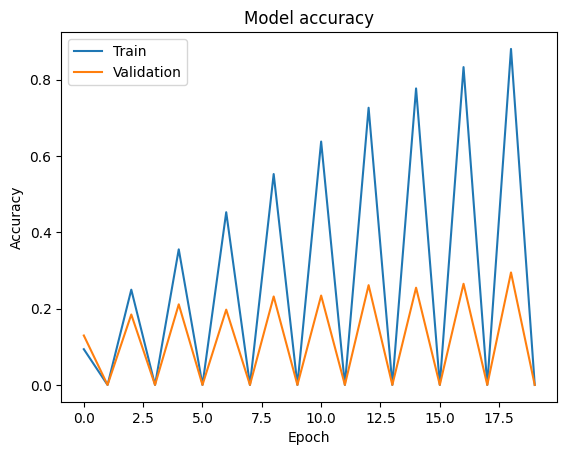

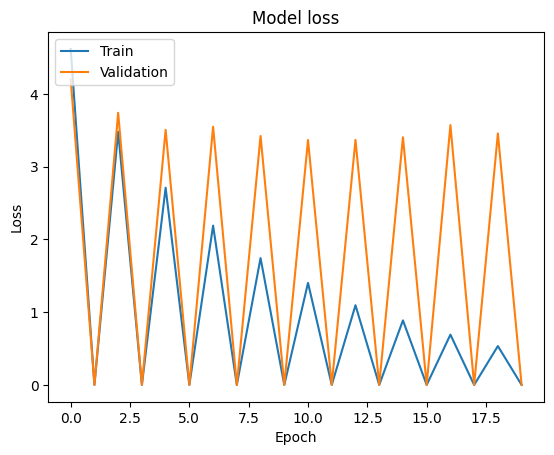

In [31]:
import matplotlib.pyplot as plt

# Wizualizacja dokładności
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Wizualizacja straty
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


In [32]:
model2.save('/Users/milenabiernacka/Desktop/praca-magisterska/Mushroom-classification/models/model_10epochs_MobileNetV2/model2.h5')  # Zapisuje model w folderze SavedModel

In [33]:
from tensorflow.keras.losses import CategoricalFocalCrossentropy
# Zbudowanie modelu
model3 = Model(inputs=base_model.input, outputs=predictions)

# Kompilacja modelu
model3.compile(optimizer=Adam(learning_rate=0.0001), loss=CategoricalFocalCrossentropy(), metrics=['accuracy'])

history3 = model3.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(val_generator)
)

Epoch 1/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 299s 2s/step - accuracy: 0.8945 - loss: 0.0561 - val_accuracy: 0.2928 - val_loss: 0.7821
Epoch 2/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 575us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 3/20


2024-03-25 11:22:04.112843: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-03-25 11:22:04.136795: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


155/155 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.9178 - loss: 0.0431 - val_accuracy: 0.2989 - val_loss: 0.7841
Epoch 4/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 172us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 5/20


2024-03-25 11:27:23.752216: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 11:27:23.760486: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


155/155 ━━━━━━━━━━━━━━━━━━━━ 336s 2s/step - accuracy: 0.9363 - loss: 0.0318 - val_accuracy: 0.2783 - val_loss: 0.8372
Epoch 6/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 157us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 7/20


2024-03-25 11:33:00.021097: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 11:33:00.028762: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


155/155 ━━━━━━━━━━━━━━━━━━━━ 350s 2s/step - accuracy: 0.9341 - loss: 0.0327 - val_accuracy: 0.2934 - val_loss: 0.8673
Epoch 8/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 9/20


2024-03-25 11:38:49.981659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 11:38:49.991078: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


155/155 ━━━━━━━━━━━━━━━━━━━━ 403s 3s/step - accuracy: 0.9345 - loss: 0.0274 - val_accuracy: 0.2904 - val_loss: 0.8637
Epoch 10/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 171us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 11/20


2024-03-25 11:45:32.755204: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 11:45:32.763359: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


155/155 ━━━━━━━━━━━━━━━━━━━━ 421s 3s/step - accuracy: 0.9337 - loss: 0.0309 - val_accuracy: 0.3116 - val_loss: 0.7993
Epoch 12/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 218us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 13/20


2024-03-25 11:52:34.125064: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 11:52:34.135642: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


155/155 ━━━━━━━━━━━━━━━━━━━━ 432s 3s/step - accuracy: 0.9543 - loss: 0.0240 - val_accuracy: 0.2940 - val_loss: 0.8571
Epoch 14/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 184us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 15/20


2024-03-25 11:59:46.176494: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 11:59:46.185490: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


155/155 ━━━━━━━━━━━━━━━━━━━━ 428s 3s/step - accuracy: 0.9429 - loss: 0.0245 - val_accuracy: 0.3079 - val_loss: 0.8460
Epoch 16/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 221us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 17/20


2024-03-25 12:06:53.961826: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 12:06:53.972327: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


155/155 ━━━━━━━━━━━━━━━━━━━━ 416s 3s/step - accuracy: 0.9442 - loss: 0.0236 - val_accuracy: 0.3182 - val_loss: 0.8155
Epoch 18/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 160us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00
Epoch 19/20


2024-03-25 12:13:49.788047: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 12:13:49.795805: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


155/155 ━━━━━━━━━━━━━━━━━━━━ 426s 3s/step - accuracy: 0.9480 - loss: 0.0236 - val_accuracy: 0.3291 - val_loss: 0.7852
Epoch 20/20
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 238us/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.0000e+00 - val_loss: 0.0000e+00


2024-03-25 12:20:55.778992: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-03-25 12:20:55.789571: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


In [34]:
# Ocena modelu na zbiorze testowym
test_loss, test_accuracy = model3.evaluate(test_generator)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

52/52 ━━━━━━━━━━━━━━━━━━━━ 39s 747ms/step - accuracy: 0.3378 - loss: 0.7794
Test Loss: 0.786473274230957
Test Accuracy: 0.34119781851768494


In [35]:
model3.save('/Users/milenabiernacka/Desktop/praca-magisterska/Mushroom-classification/models/model_10epochs_MobileNetV2/model3.h5')  # Zapisuje model w folderze SavedModel

In [ ]:
history_x = model3.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=5,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size
)